In [1]:
import os
print(os.getcwd())
os.chdir("..")

/home/icb/florin.ratajczak/ppi-core-genes/notebooks


In [2]:
from speos.utils.config import Config
from speos.models import ModelBootstrapper
from speos.datasets import DatasetBootstrapper
from speos.preprocessing.mappers import GWASMapper, AdjacencyMapper

/home/icb/florin.ratajczak/anaconda3/envs/compat/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378098133/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


In [393]:
config = Config()
#config.parse_yaml("configs/config_immune_dysregulation_film_forreal.yaml")
config.parse_yaml("configs/config_immune_dysregulation_tag.yaml")
#config.parse_yaml("configs/config_immune_dysregulation_gcn_tronly.yaml")
#config.parse_yaml("configs/config_immune_dysregulation_mlp_new.yaml")
#config.parse_yaml("configs/config_immune_dysregulation_n2vmlp_tronly.yaml")
#config.parse_yaml("configs/config_cardiovascular_film.yaml")
#config.parse_yaml("configs/config_cardiovascular_tag.yaml")
#config.parse_yaml("configs/config_cardiovascular_mlp.yaml")
#config.parse_yaml("configs/config_cardiovascular_n2vmlp.yaml")
#config.parse_yaml("configs/config_cardiovascular_gcn.yaml")

In [394]:
pre_mappings = pre_mappings = GWASMapper().get_mappings(config.input.tag, fields=config.input.field)

adjacencies = AdjacencyMapper(config.input.adjacency_mappings, blacklist=config.input.adjacency_blacklist).get_mappings(config.input.adjacency, fields=config.input.adjacency_field)

dataset = DatasetBootstrapper(pre_mappings, adjacencies, holdout_size=config.input.holdout_size, name="test", config=config).get_dataset()
dataset.preprocessor.build_graph(features=True)

node_data = dataset.data
input_dim = node_data.x.shape[1]



immune_dysregulation_film_forreal 2023-01-02 15:15:14,182 [INFO] speos.preprocessing.preprocessor: Name: 
Type: MultiDiGraph
Number of nodes: 17024
Number of edges: 160962
Average in degree:   9.4550
Average out degree:   9.4550
immune_dysregulation_film_forreal 2023-01-02 15:14:46,643 [INFO] speos.datasets: Data(x=[17024, 193], edge_index=[2, 160962], y=[17024], train_mask=[17024], test_mask=[17024], val_mask=[17024])
immune_dysregulation_film_forreal 2023-01-02 15:17:04,408 [INFO] speos.preprocessing.preprocessor: Using Adjacency matrices: ['IntActDirect']
immune_dysregulation_film_forreal 2023-01-02 15:17:04,408 [INFO] speos.preprocessing.preprocessor: Using 7 mappings with ground truth data/mendelian_gene_sets/Immune_Dysregulation_genes.bed 
immune_dysregulation_film_forreal 2023-01-02 15:17:04,414 [INFO] speos.datasets: Loading Processed Data from ./data/processed/immune_dysregulation_tag.pt


In [395]:
model = ModelBootstrapper(
            config, input_dim, len(adjacencies)).get_model()

In [396]:
if not "tronly" in config.name:
    config.name += "_outer_0_fold_1"

from speos.helpers import CheckPointer
checkpointer = CheckPointer(
                model, config.model.save_dir + config.name, mode=config.es.mode)

checkpointer.restore()

(8, 0.17203042715036523)

In [397]:
model.architectures[0] = model.architectures[0].double()

In [398]:
before_mp = model.architectures[0].pre_mp(dataset.data.x)

In [399]:
try:
    from speos.utils.nn_utils import typed_edges_to_sparse_tensor
    edges, encoder = typed_edges_to_sparse_tensor(dataset.data.x, dataset.data.edge_index_dict)
    after_mp = model.architectures[0].mp(before_mp, edges)
except AttributeError:
    try:
        after_mp = model.architectures[0].mp(before_mp, dataset.data.edge_index)
    except (TypeError, KeyError):
        after_mp = before_mp

In [431]:
def get_pretty_disease_name(config):
    if "immune" in config.name:
        return "Immune_Dysregulation"
    elif "cardio" in config.name:
        return "Cardiovascular_Disease"
    elif "bm_disorder" in config.name:
        return "Body_Mass_Disorders"
    elif "insulin" in config.name:
        return "Insulin_Disorders"
    elif "diabetes" in config.name:
        return "Diabetes"

In [432]:
import pandas as pd

results_df = pd.read_csv("results/master_tables/{}_master_table.csv".format(get_pretty_disease_name(config)), sep="\t", header=0)
#results_df = pd.read_csv("results/master_tables/Cardiovascular_Disease_master_table.csv", sep="\t", header=0)

results_df = results_df[results_df["Is Included"]]
results_df["order"] = [dataset.preprocessor.hgnc2id[hgnc] for hgnc in results_df["HGNC"]]
results_df = results_df.sort_values(by="order")

import numpy as np
assert results_df["Mendelian"].sum() == dataset.data.y.sum()
assert (np.asarray(results_df["Mendelian"]) == dataset.data.y.detach().numpy().astype(np.bool8)).all()

In [433]:
import umap
test = umap.UMAP()


In [402]:
input_reducer = umap.UMAP()
input_embedding = input_reducer.fit_transform(dataset.data.x.detach().numpy())

In [403]:
reducer = umap.UMAP()
pre_embedding = reducer.fit_transform(before_mp.detach().cpu().numpy())
pre_embedding.shape

(17024, 2)

In [404]:
post_reducer = umap.UMAP()
post_embedding = post_reducer.fit_transform(after_mp.detach().cpu().numpy())
post_embedding.shape

(17024, 2)

In [405]:
new_postmp = model.architectures[0].post_mp[:4]
final_x = new_postmp(after_mp)
final_reducer = umap.UMAP()
final_embedding = final_reducer.fit_transform(final_x.detach().cpu().numpy())
final_embedding.shape


(17024, 2)

In [406]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

In [407]:
start = 0.0
stop = 1.0
number_of_lines = 12
cm_subsection = np.linspace(start, stop, number_of_lines)

colors = [cm.viridis(x) for x in cm_subsection]

In [408]:
true_colors = colors[:]

In [409]:
colors[-1] = tuple((colors[-1][0], colors[-1][1], colors[-1][2], 0.2))

In [422]:
def get_pretty_name(config):
    if "n2v" in config.name:
        return "N2V+MLP"
    elif "mlp" in config.name:
        return "MLP"
    elif "gcn" in config.name:
        return "GCN"
    elif "tag" in config.name:
        return "TAG"
    elif "film" in config.name:
        return "FiLM"

In [428]:
from speos.visualization.settings import *
import matplotlib.pyplot as plt
import matplotlib as mpl
cmap = mpl.cm.viridis

width_ratios =  [0.87, 1,]

fig, axes = plt.subplots(2, 2, figsize=(full_width*cm,17*cm), gridspec_kw={"width_ratios": width_ratios})

cmap = (mpl.colors.ListedColormap(true_colors[::-1] + ["red"]))

pretty_name = get_pretty_name(config)

for datatype in ["png", "svg"]:
    for i, (ax, embeddings, title) in enumerate(zip(axes.flatten(), (input_embedding, pre_embedding, post_embedding, final_embedding), ("Input", "Pre-MP", "Post-MP", "Final"))):
        if i % 2 == 1:
            labels = [str(x) for x in range(12)] + ["M"]
            bounds = np.asarray(range(0, len(colors) + 2)) - 0.5
            norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
            cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                                        ax=ax,
                                        label="CS / Mendelian",
                                        ticks=range(0, len(colors) + 2),
                                        pad=0.02)
            cbar.ax.set_yticklabels(labels + [""])

        ax.scatter(
        embeddings[:, 0],
        embeddings[:, 1],
        s=1,
        c=[colors[::-1][int(y)] if x == 0 else "red" for x, y in zip(dataset.data.y.detach().cpu().numpy(), results_df["CS {}".format(pretty_name)],)],
        rasterized=True)
        ax.set_aspect('equal', 'datalim')
        ax.set_title(title, fontsize=large_font)


    fig.tight_layout()
    fig.savefig("plots/UMAP_{}.{}".format(config.name, datatype), dpi = 350, facecolor="white")
    plt.clf()

/home/icb/florin.ratajczak/anaconda3/envs/compat/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


<Figure size 510.236x481.89 with 0 Axes>

In [152]:
dge_categories = [column.startswith("DGE:") for column in results_df.columns]

In [156]:
dge_df = results_df.loc[:, dge_categories]

In [176]:
which_dge = np.nonzero(dge_df.values)

color_list = []
for i in range(len(results_df)):
    if i in which_dge[0]:
        color_list.append(sns.color_palette()[ which_dge[1][np.nonzero(which_dge[0] == i)[0][0] ]] )
    else:
        color_list.append("gray")

In [173]:
which_dge[1][np.nonzero(which_dge[0] == 50)[0][0]]

3

/home/icb/florin.ratajczak/anaconda3/envs/compat/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


Text(0.5, 1.0, 'UMAP projection of the X_postMP')

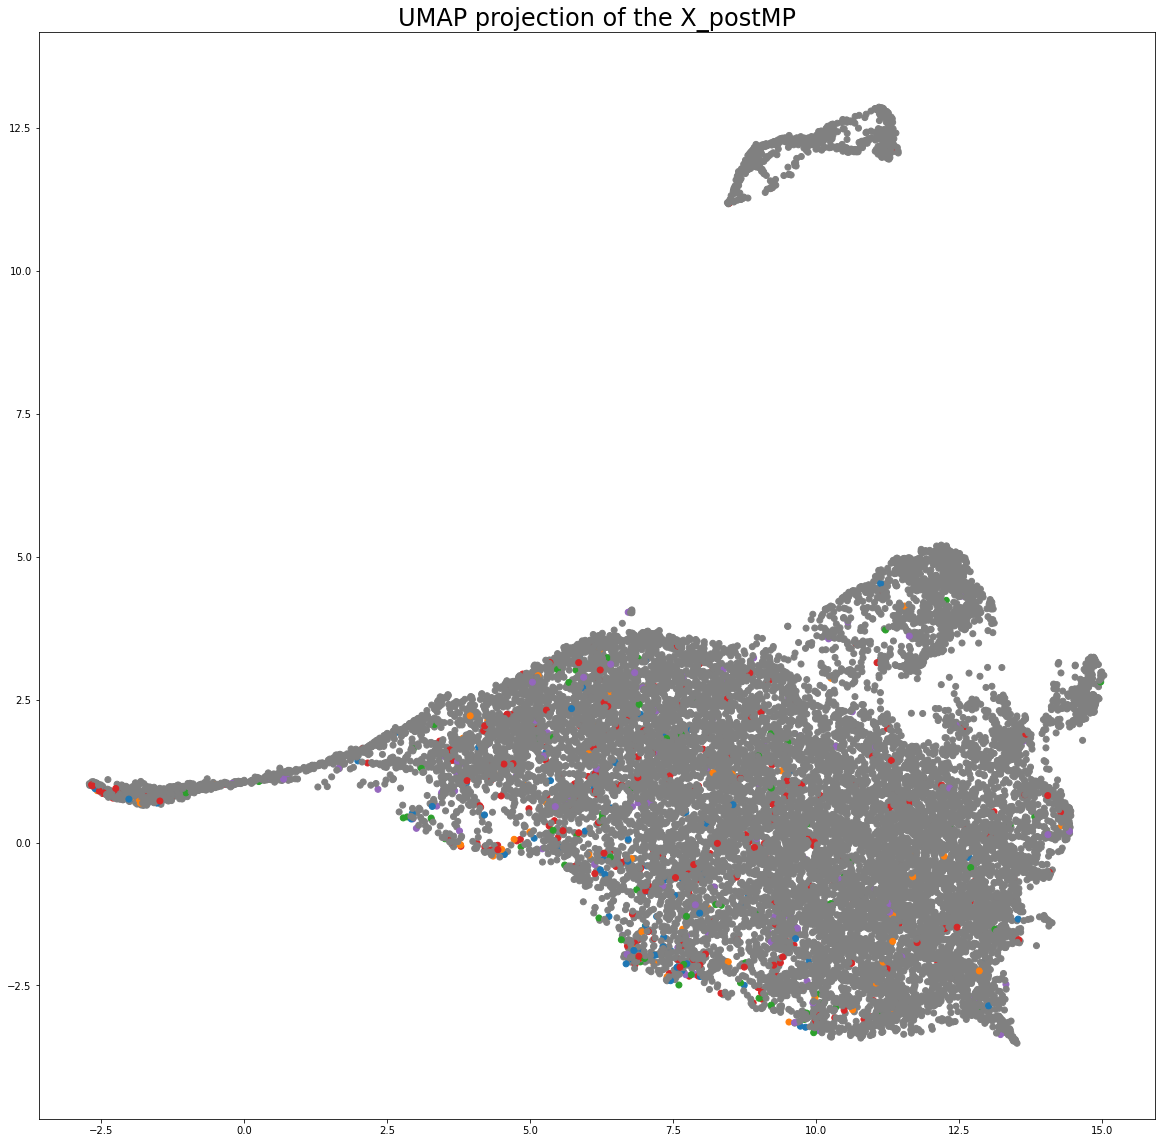

In [177]:
fig, ax = plt.subplots(1,1,figsize=(20,20))

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=color_list)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the X_postMP', fontsize=24)

In [44]:
height_ratios = [[1, 1, 1], [1, 1, 1]]
width_ratios =  [[1, 1, 1], [1, 1, 1]]

fig, axes = plt.subplots(2, 3, figsize=(full_width*cm, 17*cm), gridspec_kw={'width_ratios': width_ratios, 'height_ratios': height_ratios})

ValueError: Expected the given number of width ratios to match the number of columns of the grid

<Figure size 510.236x481.89 with 0 Axes>

In [72]:
labels = [str(x) for x in range(12)] + ["M"]

In [73]:
len(labels)

13

In [411]:
labels

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', 'M']

# Control model parameters

In [5]:
config = Config()
#config.parse_yaml("configs/config_immune_dysregulation_film_forreal.yaml")
config.parse_yaml("configs/config_immune_dysregulation_tag.yaml")

pre_mappings = pre_mappings = GWASMapper().get_mappings(config.input.tag, fields=config.input.field)

adjacencies = AdjacencyMapper(config.input.adjacency_mappings, blacklist=config.input.adjacency_blacklist).get_mappings(config.input.adjacency, fields=config.input.adjacency_field)

dataset = DatasetBootstrapper(pre_mappings, adjacencies, holdout_size=config.input.holdout_size, name="test", config=config).get_dataset()
dataset.preprocessor.build_graph(features=True)

node_data = dataset.data
input_dim = node_data.x.shape[1]

immune_dysregulation_tag 2023-01-09 17:28:33,400 [INFO] speos.preprocessing.preprocessor: Using Adjacency matrices: ['IntActDirect']
immune_dysregulation_tag 2023-01-09 17:28:33,400 [INFO] speos.preprocessing.preprocessor: Using 7 mappings with ground truth data/mendelian_gene_sets/Immune_Dysregulation_genes.bed 
immune_dysregulation_tag 2023-01-09 17:28:35,274 [INFO] speos.datasets: Loading Processed Data from ./data/processed/immune_dysregulation_tag.pt


In [16]:
for disease in ["immune_dysregulation", "cardiovascular", "bm_disorder", "insulin_disorder", "diabetes"]:
    dataset = None
    print(disease)
    for method in ["tag", "film", "gcn", "mlp", "film_unbiased", "n2vmlp"]:
        config = Config()
        
        if method == "film" and disease == "immune_dysregulation":
            method += "_forreal"

        if method in ["gcn", "mlp", "n2vmlp"] and disease == "immune_dysregulation":
            method += "_new"
            
        print(method)
        #config.parse_yaml("configs/config_immune_dysregulation_film_forreal.yaml")
        config.parse_yaml("configs/config_{}_{}.yaml".format(disease, method))

        pre_mappings = GWASMapper().get_mappings(config.input.tag, fields=config.input.field)

        adjacencies = AdjacencyMapper(config.input.adjacency_mappings, blacklist=config.input.adjacency_blacklist).get_mappings(config.input.adjacency, fields=config.input.adjacency_field)

        if dataset is None or "n2v" in method:
            
            dataset = DatasetBootstrapper(pre_mappings, adjacencies, holdout_size=config.input.holdout_size, name="test", config=config).get_dataset()
            dataset.preprocessor.build_graph(features=True)

            node_data = dataset.data
            input_dim = node_data.x.shape[1]

        model = ModelBootstrapper(
                    config, input_dim, len(adjacencies)).get_model()

        config.name += "_outer_0_fold_1"

        from speos.helpers import CheckPointer
        checkpointer = CheckPointer(
                        model, config.model.save_dir + config.name, mode=config.es.mode)

        checkpointer.restore()

        model.architectures[0] = model.architectures[0].double()
        before_mp = model.architectures[0].pre_mp(dataset.data.x)

    print("Clear for {}.".format(disease))

immune_dysregulation_tag 2023-01-09 17:43:37,251 [INFO] speos.datasets: Data(x=[17024, 93], edge_index=[2, 14411], y=[17024], train_mask=[17024], test_mask=[17024], val_mask=[17024])
immune_dysregulation_tag 2023-01-09 17:43:44,526 [INFO] speos.preprocessing.preprocessor: Using Adjacency matrices: ['IntActDirect']
immune_dysregulation_tag 2023-01-09 17:43:44,526 [INFO] speos.preprocessing.preprocessor: Using 7 mappings with ground truth data/mendelian_gene_sets/Immune_Dysregulation_genes.bed 
immune_dysregulation_tag 2023-01-09 17:43:44,530 [INFO] speos.datasets: Loading Processed Data from ./data/processed/immune_dysregulation_tag.pt


immune_dysregulation
tag
film_forreal
gcn_new
mlp_new
film_unbiased


immune_dysregulation_tag 2023-01-09 17:44:04,463 [INFO] speos.preprocessing.preprocessor: Name: 
Type: MultiDiGraph
Number of nodes: 17024
Number of edges: 14411
Average in degree:   0.8465
Average out degree:   0.8465
immune_dysregulation_tag 2023-01-09 17:43:44,556 [INFO] speos.datasets: Data(x=[17024, 93], edge_index=[2, 14411], y=[17024], train_mask=[17024], test_mask=[17024], val_mask=[17024])
immune_dysregulation_tag 2023-01-09 17:44:07,285 [INFO] speos.preprocessing.preprocessor: Using Adjacency matrices: ['BioPlex30293T']
immune_dysregulation_tag 2023-01-09 17:44:07,286 [INFO] speos.preprocessing.preprocessor: Using 7 mappings with ground truth data/mendelian_gene_sets/Immune_Dysregulation_genes.bed 


n2vmlp_new


immune_dysregulation_tag 2023-01-09 17:44:07,343 [INFO] speos.datasets: Loading Processed Data from ./data/processed/immune_dysregulation_n2vmlp_new.pt
immune_dysregulation_tag 2023-01-09 17:44:48,363 [INFO] speos.preprocessing.preprocessor: Name: 
Type: MultiDiGraph
Number of nodes: 17024
Number of edges: 160962
Average in degree:   9.4550
Average out degree:   9.4550
immune_dysregulation_tag 2023-01-09 17:44:07,609 [INFO] speos.datasets: Data(x=[17024, 193], edge_index=[2, 160962], y=[17024], train_mask=[17024], test_mask=[17024], val_mask=[17024])
immune_dysregulation_tag 2023-01-09 17:44:48,670 [INFO] speos.preprocessing.preprocessor: Using Adjacency matrices: ['IntActDirect']
immune_dysregulation_tag 2023-01-09 17:44:48,670 [INFO] speos.preprocessing.preprocessor: Using 8 mappings with ground truth data/mendelian_gene_sets/Cardiovascular_Disease_genes.bed 


Clear for immune_dysregulation.
cardiovascular
tag


immune_dysregulation_tag 2023-01-09 17:44:48,721 [INFO] speos.datasets: Loading Processed Data from ./data/processed/cardiovascular_tag.pt


film
gcn
mlp
film_unbiased


immune_dysregulation_tag 2023-01-09 17:45:11,740 [INFO] speos.preprocessing.preprocessor: Name: 
Type: MultiDiGraph
Number of nodes: 17320
Number of edges: 14882
Average in degree:   0.8592
Average out degree:   0.8592
immune_dysregulation_tag 2023-01-09 17:44:48,918 [INFO] speos.datasets: Data(x=[17320, 96], edge_index=[2, 14882], y=[17320], train_mask=[17320], test_mask=[17320], val_mask=[17320])
immune_dysregulation_tag 2023-01-09 17:45:12,718 [INFO] speos.preprocessing.preprocessor: Using Adjacency matrices: ['BioPlex30293T']
immune_dysregulation_tag 2023-01-09 17:45:12,718 [INFO] speos.preprocessing.preprocessor: Using 8 mappings with ground truth data/mendelian_gene_sets/Cardiovascular_Disease_genes.bed 


n2vmlp


immune_dysregulation_tag 2023-01-09 17:45:12,773 [INFO] speos.datasets: Loading Processed Data from ./data/processed/cardiovascular_n2vmlp.pt
immune_dysregulation_tag 2023-01-09 17:45:38,334 [INFO] speos.preprocessing.preprocessor: Name: 
Type: MultiDiGraph
Number of nodes: 17320
Number of edges: 168112
Average in degree:   9.7062
Average out degree:   9.7062
immune_dysregulation_tag 2023-01-09 17:45:12,984 [INFO] speos.datasets: Data(x=[17320, 196], edge_index=[2, 168112], y=[17320], train_mask=[17320], test_mask=[17320], val_mask=[17320])
immune_dysregulation_tag 2023-01-09 17:45:38,611 [INFO] speos.preprocessing.preprocessor: Using Adjacency matrices: ['IntActDirect']
immune_dysregulation_tag 2023-01-09 17:45:38,611 [INFO] speos.preprocessing.preprocessor: Using 7 mappings with ground truth data/mendelian_gene_sets/Body_Mass_Disorder_genes.bed 


Clear for cardiovascular.
bm_disorder
tag


immune_dysregulation_tag 2023-01-09 17:45:38,673 [INFO] speos.datasets: Loading Processed Data from ./data/processed/bm_disorder_tag.pt


film
gcn
mlp
film_unbiased


immune_dysregulation_tag 2023-01-09 17:45:59,077 [INFO] speos.preprocessing.preprocessor: Name: 
Type: MultiDiGraph
Number of nodes: 17398
Number of edges: 14937
Average in degree:   0.8585
Average out degree:   0.8585
immune_dysregulation_tag 2023-01-09 17:45:38,845 [INFO] speos.datasets: Data(x=[17398, 93], edge_index=[2, 14937], y=[17398], train_mask=[17398], test_mask=[17398], val_mask=[17398])
immune_dysregulation_tag 2023-01-09 17:46:00,453 [INFO] speos.preprocessing.preprocessor: Using Adjacency matrices: ['BioPlex30293T']
immune_dysregulation_tag 2023-01-09 17:46:00,453 [INFO] speos.preprocessing.preprocessor: Using 7 mappings with ground truth data/mendelian_gene_sets/Body_Mass_Disorder_genes.bed 


n2vmlp


immune_dysregulation_tag 2023-01-09 17:46:00,558 [INFO] speos.datasets: Loading Processed Data from ./data/processed/bm_disorder_n2vmlp.pt


Clear for bm_disorder.
insulin_disorder
tag


immune_dysregulation_tag 2023-01-09 17:46:25,179 [INFO] speos.preprocessing.preprocessor: Name: 
Type: MultiDiGraph
Number of nodes: 17398
Number of edges: 169038
Average in degree:   9.7159
Average out degree:   9.7159
immune_dysregulation_tag 2023-01-09 17:46:00,827 [INFO] speos.datasets: Data(x=[17398, 193], edge_index=[2, 169038], y=[17398], train_mask=[17398], test_mask=[17398], val_mask=[17398])
immune_dysregulation_tag 2023-01-09 17:46:25,597 [INFO] speos.preprocessing.preprocessor: Using Adjacency matrices: ['IntActDirect']
immune_dysregulation_tag 2023-01-09 17:46:25,597 [INFO] speos.preprocessing.preprocessor: Using 4 mappings with ground truth data/mendelian_gene_sets/Insulin_Disorder_genes.bed 
immune_dysregulation_tag 2023-01-09 17:46:25,806 [INFO] speos.datasets: Loading Processed Data from ./data/processed/insulin_disorder_tag.pt


film
gcn
mlp
film_unbiased


immune_dysregulation_tag 2023-01-09 17:46:41,020 [INFO] speos.preprocessing.preprocessor: Name: 
Type: MultiDiGraph
Number of nodes: 17401
Number of edges: 14941
Average in degree:   0.8586
Average out degree:   0.8586
immune_dysregulation_tag 2023-01-09 17:46:26,085 [INFO] speos.datasets: Data(x=[17401, 84], edge_index=[2, 14941], y=[17401], train_mask=[17401], test_mask=[17401], val_mask=[17401])
immune_dysregulation_tag 2023-01-09 17:46:42,012 [INFO] speos.preprocessing.preprocessor: Using Adjacency matrices: ['BioPlex30293T']
immune_dysregulation_tag 2023-01-09 17:46:42,012 [INFO] speos.preprocessing.preprocessor: Using 4 mappings with ground truth data/mendelian_gene_sets/Insulin_Disorder_genes.bed 


n2vmlp


immune_dysregulation_tag 2023-01-09 17:46:42,040 [INFO] speos.datasets: Loading Processed Data from ./data/processed/insulin_disorder_n2vmlp.pt
immune_dysregulation_tag 2023-01-09 17:47:00,229 [INFO] speos.preprocessing.preprocessor: Name: 
Type: MultiDiGraph
Number of nodes: 17401
Number of edges: 169186
Average in degree:   9.7228
Average out degree:   9.7228
immune_dysregulation_tag 2023-01-09 17:46:42,255 [INFO] speos.datasets: Data(x=[17401, 184], edge_index=[2, 169186], y=[17401], train_mask=[17401], test_mask=[17401], val_mask=[17401])
immune_dysregulation_tag 2023-01-09 17:47:00,467 [INFO] speos.preprocessing.preprocessor: Using Adjacency matrices: ['IntActDirect']
immune_dysregulation_tag 2023-01-09 17:47:00,467 [INFO] speos.preprocessing.preprocessor: Using 6 mappings with ground truth data/mendelian_gene_sets/Monogenic_Diabetes_genes.bed 


Clear for insulin_disorder.
diabetes
tag


immune_dysregulation_tag 2023-01-09 17:47:00,658 [INFO] speos.datasets: Loading Processed Data from ./data/processed/diabetes_tag.pt


film
gcn
mlp
film_unbiased


immune_dysregulation_tag 2023-01-09 17:47:19,316 [INFO] speos.preprocessing.preprocessor: Name: 
Type: MultiDiGraph
Number of nodes: 17406
Number of edges: 14939
Average in degree:   0.8583
Average out degree:   0.8583
immune_dysregulation_tag 2023-01-09 17:47:00,794 [INFO] speos.datasets: Data(x=[17406, 90], edge_index=[2, 14939], y=[17406], train_mask=[17406], test_mask=[17406], val_mask=[17406])
immune_dysregulation_tag 2023-01-09 17:47:20,349 [INFO] speos.preprocessing.preprocessor: Using Adjacency matrices: ['BioPlex30293T']
immune_dysregulation_tag 2023-01-09 17:47:20,349 [INFO] speos.preprocessing.preprocessor: Using 6 mappings with ground truth data/mendelian_gene_sets/Monogenic_Diabetes_genes.bed 


n2vmlp


immune_dysregulation_tag 2023-01-09 17:47:20,389 [INFO] speos.datasets: Loading Processed Data from ./data/processed/diabetes_n2vmlp.pt


Clear for diabetes.


In [4]:
print(os.getcwd())

/home/icb/florin.ratajczak/ppi-core-genes
